In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm

base_path = "/kaggle/input/skin-cancer-malignant-vs-benign"
benign_path = os.path.join(base_path, "benign")
malignant_path = os.path.join(base_path, "malignant")

IMG_SIZE = 128



In [6]:
base_path = "/kaggle/input/skin-cancer-malignant-vs-benign/train"
benign_path = os.path.join(base_path, "benign")
malignant_path = os.path.join(base_path, "malignant")
IMG_SIZE = 128

from tqdm import tqdm
from PIL import Image
import os
import numpy as np

def load_images_from_folder(folder_path, label):
    images = []
    for filename in tqdm(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, filename)
        try:
            img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE))
            img = np.array(img)
            if img.shape == (IMG_SIZE, IMG_SIZE, 3):  # RGB 
                images.append((img, label))
        except:
            continue
    return images

benign_data = load_images_from_folder(benign_path, "benign")
malignant_data = load_images_from_folder(malignant_path, "malignant")

data = benign_data + malignant_data
np.random.shuffle(data)

X = np.array([item[0] for item in data]) / 255.0  # Normalize
y = np.array([item[1] for item in data])


100%|██████████| 1197/1197 [00:14<00:00, 82.42it/s]


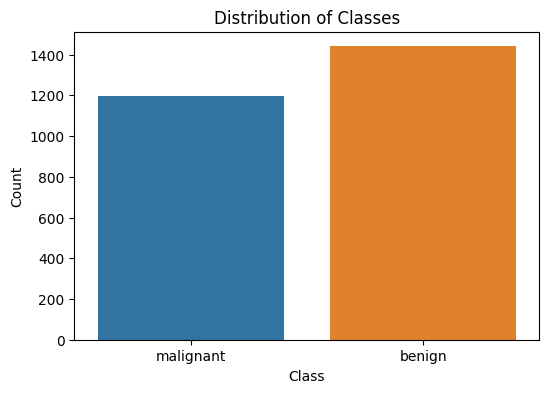

In [7]:
import seaborn as sns

df_labels = pd.DataFrame(y, columns=["label"])

plt.figure(figsize=(6, 4))
sns.countplot(data=df_labels, x="label")
plt.title("Distribution of Classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


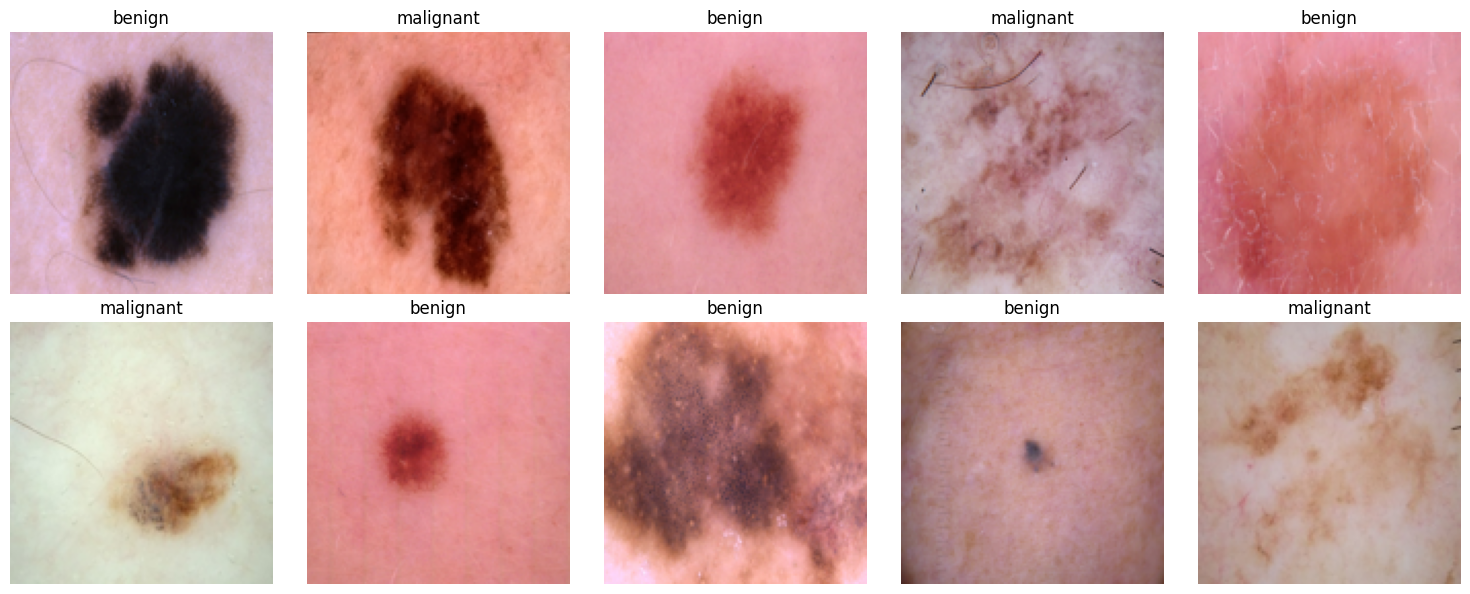

In [8]:
import random

plt.figure(figsize=(15, 6))
for i in range(10):
    idx = random.randint(0, len(X) - 1)
    plt.subplot(2, 5, i+1)
    plt.imshow(X[idx])
    plt.title(y[idx])
    plt.axis("off")
plt.tight_layout()
plt.show()


In [9]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_encoded = le.fit_transform(y)  # benign → 0, malignant → 1

y_onehot = to_categorical(y_encoded)


In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [11]:
# Normalization + Augmentation 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,         # 20% validation
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

#  Normalization  validation
valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


In [12]:
data_dir = "/kaggle/input/skin-cancer-malignant-vs-benign/train"

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 2110 images belonging to 2 classes.
Found 527 images belonging to 2 classes.


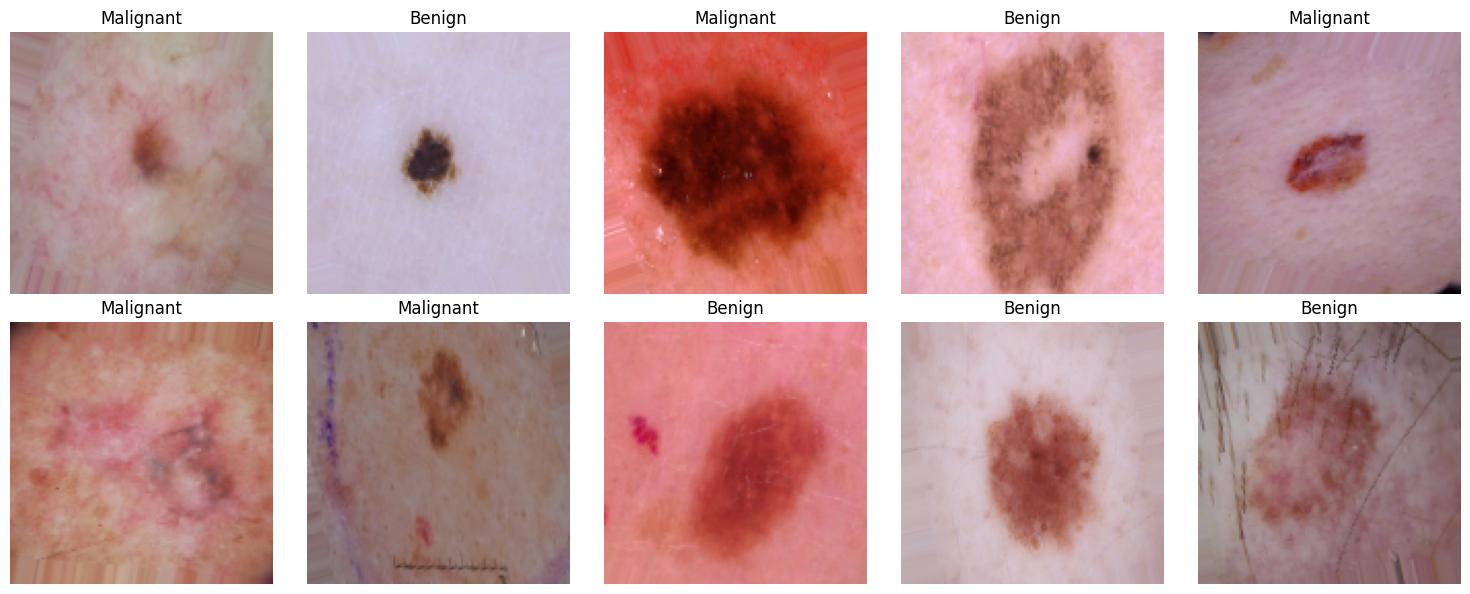

In [13]:
images, labels = next(train_generator)

plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i])
    plt.title("Benign" if np.argmax(labels[i]) == 0 else "Malignant")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [15]:
model = Sequential()

# Layer 1: Convolution + MaxPooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2: Convolution + MaxPooling
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3: Convolution + MaxPooling
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten + Fully Connected Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # لتقليل الـ overfitting
model.add(Dense(2, activation='softmax'))  # 2 classes: benign & malignant


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,914,696 (37.82 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,609,798 (25.21 MB)

In [16]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [19]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1747057511.542889      98 service.cc:148] XLA service 0x7f30c0008ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747057511.544204      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747057511.544225      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747057511.849709      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/66 ━━━━━━━━━━━━━━━━━━━━ 8:11 8s/step - accuracy: 0.4375 - loss: 0.6949

I0000 00:00:1747057515.356742      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 228ms/step - accuracy: 0.6049 - loss: 0.6485 - val_accuracy: 0.6755 - val_loss: 0.5426
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 168ms/step - accuracy: 0.7610 - loss: 0.4819 - val_accuracy: 0.7249 - val_loss: 0.5280
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 168ms/step - accuracy: 0.8041 - loss: 0.4143 - val_accuracy: 0.7723 - val_loss: 0.4819
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 164ms/step - accuracy: 0.8026 - loss: 0.4013 - val_accuracy: 0.7609 - val_loss: 0.4944
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 173ms/step - accuracy: 0.8065 - loss: 0.3961 - val_accuracy: 0.7780 - val_loss: 0.4826
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 167ms/step - accuracy: 0.8234 - loss: 0.4096 - val_accuracy: 0.7438 - val_loss: 0.4998
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 170ms/step - accuracy: 0.8225 - loss: 0.3634 - val_accuracy: 0.7894 - val_loss: 0.4785
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 171ms/step - accuracy: 0.8153 - loss: 0.3684 - val_accuracy: 0.779

****ResNet****

In [21]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [22]:
base_model = ResNet50(
    weights='imagenet',     
    include_top=False,        
    input_shape=(128, 128, 3)
)

base_model.trainable = False


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)  

model = Model(inputs=base_model.input, outputs=predictions)


In [24]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [25]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    callbacks=[early_stop]
)


Epoch 1/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 38s 351ms/step - accuracy: 0.4770 - loss: 0.8078 - val_accuracy: 0.5465 - val_loss: 0.6853
Epoch 2/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 171ms/step - accuracy: 0.5157 - loss: 0.7494 - val_accuracy: 0.5541 - val_loss: 0.6837
Epoch 3/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step - accuracy: 0.5379 - loss: 0.7258 - val_accuracy: 0.5598 - val_loss: 0.6821
Epoch 4/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 166ms/step - accuracy: 0.5224 - loss: 0.7078 - val_accuracy: 0.5560 - val_loss: 0.6799
Epoch 5/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 166ms/step - accuracy: 0.5379 - loss: 0.7069 - val_accuracy: 0.5503 - val_loss: 0.6803
Epoch 6/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 170ms/step - accuracy: 0.5352 - loss: 0.6936 - val_accuracy: 0.5636 - val_loss: 0.6767
Epoch 7/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 170ms/step - accuracy: 0.5354 - loss: 0.6956 - val_accuracy: 0.5579 - val_loss: 0.6754
Epoch 8/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 173ms/step - accuracy: 0.5584 - loss: 0.6836 - val_accu

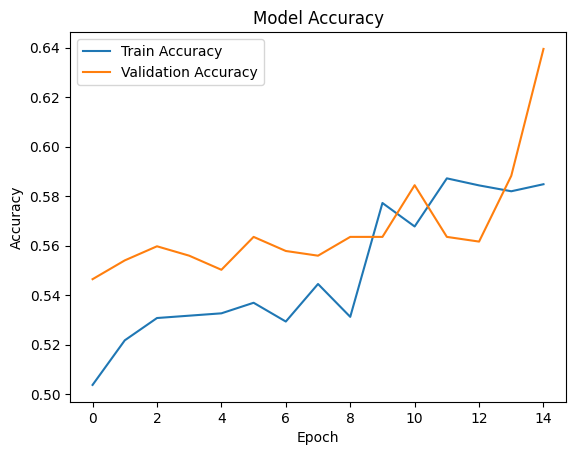

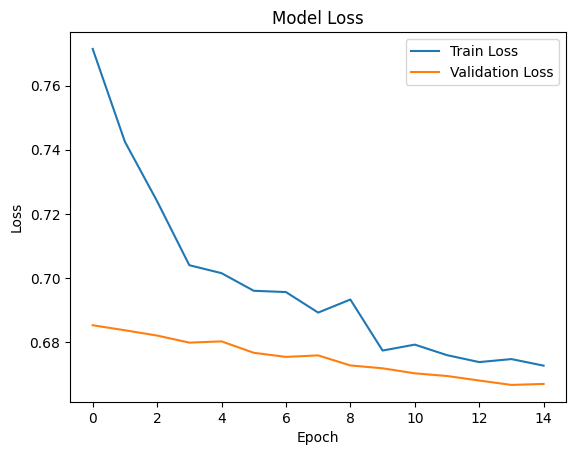

In [26]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


******finetuning******

In [27]:
# فتح بعض طبقات ResNet للتدريب (Fine-Tuning)
base_model.trainable = True

# نجمد أول 100 طبقة فقط
for layer in base_model.layers[:100]:
    layer.trainable = False


In [28]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # مهم: learning rate أصغر
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [29]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 64s 430ms/step - accuracy: 0.6410 - loss: 0.6718 - val_accuracy: 0.4535 - val_loss: 0.7170
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 174ms/step - accuracy: 0.7837 - loss: 0.4555 - val_accuracy: 0.5825 - val_loss: 0.6749
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - accuracy: 0.7877 - loss: 0.4380 - val_accuracy: 0.4668 - val_loss: 0.7035
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 178ms/step - accuracy: 0.8144 - loss: 0.3950 - val_accuracy: 0.5541 - val_loss: 0.6901
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 172ms/step - accuracy: 0.8127 - loss: 0.3850 - val_accuracy: 0.5674 - val_loss: 0.7876


In [31]:
model.save("resnet_skin_model_stage1.h5")


In [34]:
#  Import Libraries
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


In [35]:
#  Augmentation & Generators (Target Size = 224x224)

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

data_path = "/kaggle/input/skin-cancer-malignant-vs-benign/train"

train_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

valid_generator = valid_datagen.flow_from_directory(
    data_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 2110 images belonging to 2 classes.
Found 527 images belonging to 2 classes.


In [36]:
#  Build ResNet50 Base Model (Frozen)

base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False


In [37]:
#  Custom Classification Layers on top of ResNet50

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.6)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [38]:
#  Compile + Callbacks

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, verbose=1)


In [39]:
#  Initial Training

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    callbacks=[early_stop, lr_reduce]
)


Epoch 1/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 56s 572ms/step - accuracy: 0.4899 - loss: 1.2019 - val_accuracy: 0.5123 - val_loss: 0.6963 - learning_rate: 1.0000e-04
Epoch 2/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 359ms/step - accuracy: 0.4884 - loss: 0.8589 - val_accuracy: 0.5389 - val_loss: 0.6897 - learning_rate: 1.0000e-04
Epoch 3/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 362ms/step - accuracy: 0.5340 - loss: 0.7387 - val_accuracy: 0.5275 - val_loss: 0.6883 - learning_rate: 1.0000e-04
Epoch 4/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 363ms/step - accuracy: 0.4925 - loss: 0.7212 - val_accuracy: 0.5332 - val_loss: 0.6830 - learning_rate: 1.0000e-04
Epoch 5/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 357ms/step - accuracy: 0.5210 - loss: 0.6985 - val_accuracy: 0.5427 - val_loss: 0.6833 - learning_rate: 1.0000e-04
Epoch 6/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 362ms/step - accuracy: 0.5595 - loss: 0.6814 - val_accuracy: 0.6072 - val_loss: 0.6821 - learning_rate: 1.0000e-04
Epoch 7/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 360ms/step - acc

In [40]:
#  Fine-Tuning ResNet50 

base_model.trainable = True

for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stop, lr_reduce]
)


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 84s 665ms/step - accuracy: 0.6484 - loss: 0.7410 - val_accuracy: 0.4535 - val_loss: 0.6927 - learning_rate: 1.0000e-05
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 377ms/step - accuracy: 0.7616 - loss: 0.5114 - val_accuracy: 0.4535 - val_loss: 0.8728 - learning_rate: 1.0000e-05
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.7862 - loss: 0.4558
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 377ms/step - accuracy: 0.7863 - loss: 0.4557 - val_accuracy: 0.4535 - val_loss: 0.8235 - learning_rate: 1.0000e-05
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 381ms/step - accuracy: 0.7935 - loss: 0.4403 - val_accuracy: 0.4535 - val_loss: 0.7189 - learning_rate: 2.0000e-06
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 378ms/step - accuracy: 0.8009 - loss: 0.4134 - val_accuracy: 0.7856 - val_loss: 0.5973 - learning_rate: 2.0000e-06
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 379ms/step - accuracy

In [41]:
# Save the Fine-Tuned Model
model.save("resnet_skin_model_finetuned.h5")


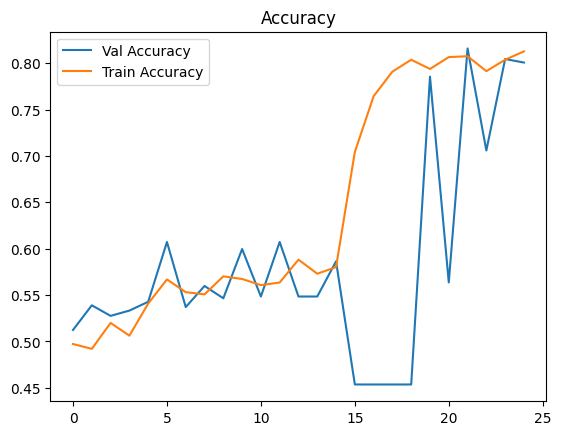

In [42]:
# 📈 Plot Accuracy & Loss

plt.plot(history.history['val_accuracy'] + history_finetune.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['accuracy'] + history_finetune.history['accuracy'], label='Train Accuracy')
plt.title("Accuracy")
plt.legend()
plt.show()


In [43]:
test_path = "/kaggle/input/skin-cancer-malignant-vs-benign/test"

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

loss, acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {acc*100:.2f}%")


Found 660 images belonging to 2 classes.
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - accuracy: 0.7959 - loss: 0.3600
✅ Test Accuracy: 82.58%


21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 275ms/step
              precision    recall  f1-score   support

      benign       0.87      0.79      0.83       360
   malignant       0.78      0.86      0.82       300

    accuracy                           0.83       660
   macro avg       0.83      0.83      0.83       660
weighted avg       0.83      0.83      0.83       660



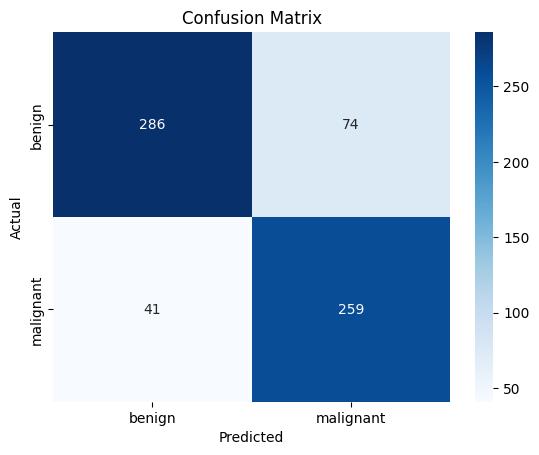

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# التنبؤات
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# القيم الحقيقية
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# تقرير التصنيف
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# مصفوفة الارتباك
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
